<a href="https://colab.research.google.com/github/GDdeCastro/Computational_Methods_in_Physics/blob/main/Poisson_Equation_Solution_and_Electrostatic_Field_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
from matplotlib.animation import PillowWriter
import matplotlib.animation as animation

# defining values for constants, in case one wants to see what
# results the real values would give

#e = 1.602*10**-19 # C
#epsilon_0 = 8.85*10**-12 # C²/N²m²

epsilon_0 = 1

def create_grid(Lx, Ly, dx, dy):
  '''
  This function creates the grid environment (x and y) in steps
  of dx and dy
  '''
  x = np.arange(0,Lx+dx,dx)
  y = np.arange(0,Ly+dy,dy)

  xsize = round(Lx/dx)+1
  ysize = round(Ly/dy)+1
  return x, y, xsize, ysize

# Initiating the potential and field matrixes

def initiate_matrices(xsize,ysize):

  '''
  This function creates all necessary matrices for a complete simulation
  V, Ex, Ey, rho and V_old
  '''
  
  V = np.zeros( (xsize,ysize) )
  V_old = np.zeros( (xsize,ysize) )

  Ex = np.zeros( (xsize,ysize) )
  Ey = np.zeros( (xsize,ysize) )

  rho = np.zeros((xsize,ysize))
  return V, V_old, Ex, Ey, rho

# Creating the matrix with the charge distribution

def create_rho(rho, x_position = None, y_position = None, charge = None):
  '''
  This function adds the charges to the wanted positions

  positions are lists of coordinates:

  ex:

  3 charges
  x_position = [0,.5,1]
  y_position = [0.5,0.5,0.5]
  charge = [-1,1,-1]
  '''
  
  if x_position != None: 

    x_position = np.round(np.array(x_position)/dx)
    y_position = np.round(np.array(y_position)/dy)
    # print(x_position)
    charge = np.array(charge)

    cont = 0
    while cont < np.size(x_position):
      rho[int(x_position[cont]),int(y_position[cont])] = charge[cont]
      cont += 1

# defining the function to calculate the field given any potential

def E(V, Ex, Ey):
  '''
  This function calculates the field components and adds them to the matrices
  Ex and Ey given a potential V
  '''
  
  global dx
  global dy

  # loop for the inner grid of the fields
  for i in range(1, xsize-1):
            for j in range(1, ysize-1):
                Ex[i,j] = (-1/(2*dx)) * (V_old[i+1,j] - V_old[i-1,j])
                Ey[i,j] = (-1/(2*dy)) * (V_old[i,j+1] - V_old[i,j-1])
                
  # border of the fields (the derivative has to be different here)
  Ex[0,:] = (-1/(dx)) * (V_old[1,:] - V_old[0,:])
  Ex[xsize-1,:] = (-1/(dx)) * (V_old[xsize-1,:] - V_old[xsize-2,:])
  Ey[:,0] = (-1/(dy)) * (V_old[:,1] - V_old[:,0])
  Ey[:,ysize-1] = (-1/(dy)) * (V_old[:,ysize-1] - V_old[:,ysize-2])

# calculating the differente between the new iterated solution and the last one
# this is done so we know when the new iterations are becoming "irrelevant"
def delta(V, V_old):
  '''
  Calculates the delta parameter given two matrices
  '''
  return np.sum(np.absolute(V - V_old))

def add_border_conditions(V, xsize, ysize, value = 0):
  '''
  This function adds the border conditions to the potential matrix
  (only on the grid borders)

  V is the potential matrix
  value is a contant value for potential on the borders ie 3V
  '''
  if type(value) == float or type(value) == int:
    V[0,:] = value
    V[:,0] = value
    V[xsize-1,:] = value
    V[:,ysize-1] = value

def add_capacitor(V, xs, ys_d, ys_u, cs):
  '''
  This adds parallel plates

  xs is the list of 2 x values where you'll add the plates
  ys_d is the cordinate of the bottom of the 2 plates (a list of lenght 2 as well)
  ys_u is the cordinate of the top of the 2 plates (a list of lenght 2 as well)
  cs is a list of the values of constant potential for each plate
  '''
  V[round(xs[0]/dx),round(ys_d[0]/dy):round(ys_u[0]/dy)] = cs[0]
  V[round(xs[1]/dx),round(ys_d[1]/dy):round(ys_u[1]/dy)] = cs[1]

# this defines the actual iterations of the V matrixes
def iterate(V, V_old, eps, nmax, rho, xsize, ysize, capacitor = False, xs=[0.2,0.8], ys_d=[0.1, 0.1], ys_u=[0.9,0.9], cs=[1,-1] ):
    '''
    Function that iterates V until we reach saturation or the maximum number of 
    iterations.

    V = V matrix
    V_old = last V matrix
    eps = Saturation limit
    nmax = number of iterations
    rho = matrix with the charge distribution
    '''
    global epsilon_0
    Vs = np.zeros((int(nmax), np.size(V[:,0]),np.size(V[0,:])))
    continuar = True
    k = 0
    ds = []
    for i in range(1, xsize-1):
          for j in range(1, ysize-1):
              # Solution for the charge distribution
              V[i,j] = 1/2 * (dx**2*dy**2)/(dx**2 + dy**2) * (rho[i,j])/epsilon_0

    if capacitor:
      add_capacitor(V, xs, ys_d, ys_u, cs)

    while continuar and k<nmax:

      V_old[:,:] = V[:,:]
      Vs[k] = V[:,:]
      k+=1
      for i in range(1, xsize-1):
          for j in range(1, ysize-1):
              # Solution for the Laplace equation
              V[i,j] = 1/2 * (1/(dx**2 + dy**2))*((dy**2)*(V_old[i+1,j] + V_old[i-1,j])+(dx**2)*(V_old[i,j+1]+V_old[i,j-1]))
              # Solution for the charge distribution
              if rho[i,j] != 0:
                V[i,j] = 1/2 * (dx**2*dy**2)/(dx**2 + dy**2) * (rho[i,j])/epsilon_0
      add_border_conditions(V, xsize, ysize, V_old[0,0])
      if capacitor:
        add_capacitor(V, xs, ys_d, ys_u, cs)
      ds.append(delta(V,V_old))
      if ds[-1] < eps:
          continuar = False    

    print(f'Last Delta = {ds[-1]}')
    print(f'Last iteration = {k}')  
    return Vs, k, ds

def create_delta_plot(k, ds, title):
  '''
  This function creates an evolution plot of the delta parameter
  The X axis is the iteration step.

  k is the amount of iterations
  ds is the list of deltas
  title is a string
  '''
  
  plt.clf()
  fig, ax = plt.subplots(constrained_layout=True, figsize = (12,9))
  ax.plot(np.arange(0,k,1), ds)
  ax.set_title(title, fontsize=25)
  ax.set_xlabel('Step', fontsize=20)
  ax.set_ylabel(r'$\delta$', fontsize=20)
  ax.tick_params(axis='both', which='major', labelsize=14)
  ax.tick_params(axis='both', which='minor', labelsize=14)
  ax.set_xscale('log')
  plt.savefig(title + '.png', dpi = 300)

def create_basic_potential_plot(V, x, y, title):
  '''
  This function creates and saves a potential contour plot

  It receives the potential, the x and y lists and a title string
  '''
  # potential plot
  plt.clf()
  fig, ax = plt.subplots(constrained_layout=True, figsize = (12,9))

  psm = ax.pcolormesh(x,y,np.transpose(V),shading='auto')

  cbar = plt.colorbar(psm, ax=ax, label = "V")

  cbar.ax.set_ylabel('Potencial elétrico V', fontsize='16')

  ax.set_title(title, fontsize = 25)

  ax.tick_params(axis='both', which='major', labelsize=14)
  ax.tick_params(axis='both', which='minor', labelsize=14)

  ax.set_xlabel("x[m]", fontsize=25)

  ax.set_ylabel("y[m]", fontsize=25)

  plt.savefig(title + '.png')

def create_field_plot(V, Ex, Ey, x, y, title):
  '''
  This function creates and saves a potential contour plot
  with an overlay of the electric field lines

  It receives the potential V, the
  field matrices Ex and Ey, the x and y lists and a title string

  '''
  
  # plotting the simulation potential and field
  # Fazendo os gráficos
  plt.clf()
  origin = 'lower'

  fig1, ax2 = plt.subplots(constrained_layout=True, figsize = (12,9))

  CS = ax2.contourf(x, y, np.transpose(V), 10, origin=origin) # Curvas de nivel preenchidas com cores

  # SP = ax2.streamplot(x,y,Ex.T, Ey.T, color = 'black')

  ax2.quiver(x,y,Ex.T,Ey.T)
  
  ax2.set_title(title, fontsize='25')

  ax2.set_xlabel('x[m]', fontsize='25')

  ax2.set_ylabel('y[m]', fontsize='25')

  ax2.tick_params(axis='both', which='major', labelsize=14)
  ax2.tick_params(axis='both', which='minor', labelsize=14)

  cbar = fig1.colorbar(CS)

  cbar.ax.set_ylabel('Potencial elétrico [V]', fontsize='16')
  cbar.ax.tick_params(axis='both', which='major', labelsize=14)

  plt.savefig(f"{title}.png")

def create_animation(vs, x, y, title):
  '''
  This function creates a nice animation of the evolution of
  V for each iteration

  It receives de vs object, the x and y lists and a string title
  '''
  
  # Set the figure size

  origin = 'lower'

  fig1, ax = plt.subplots(constrained_layout=True, figsize=(12,9))

  data = vs

  CS = ax.pcolormesh(x,y,np.transpose(data[0]), shading='auto')
  cbar = fig1.colorbar(CS)
  cbar.ax.set_ylabel('Potencial elétrico', fontsize='16')
  cbar.ax.tick_params(axis='both', which='major', labelsize=14)
  # Method to change the contour data points
  def animate(i):
      ax.clear()
      CS = ax.pcolormesh(x,y,np.transpose(data[i]), shading='auto')

      ax.set_title(title, fontsize='20')

      ax.set_xlabel('x[m]', fontsize='16')

      ax.set_ylabel('y[m]', fontsize='16')

      ax.text(x[-1]*0.05, y[-1]*0.9, f'Step {i}', fontsize=14, color='white')
      ax.tick_params(axis='both', which='major', labelsize=14)
      ax.tick_params(axis='both', which='minor', labelsize=14)

      #cbar = fig1.colorbar(CS)
      #cbar.ax.set_ylabel('Potencial elétrico', fontsize='16')
      #cbar.ax.tick_params(axis='both', which='major', labelsize=14)

  # Call animate method
  ani = animation.FuncAnimation(fig1, animate, k, interval=50, blit=False)

  # Display the plot
  writergif = PillowWriter(fps=50) 
  ani.save(f'{title}.gif', writer = writergif, dpi = 300)



# Paralel Plates with a charge in the middle

Last Delta = 7.355227538141662e-16
Last iteration = 600


<Figure size 432x288 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

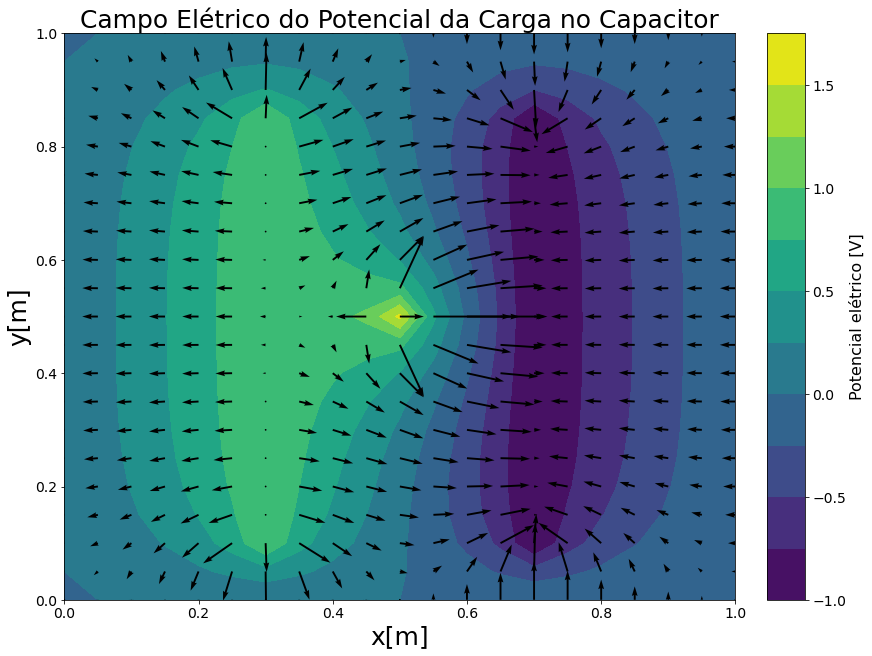

In [ ]:
# Example: Parallel Plates Capacitor + Single Charge


# Choose the grid dimensions
Lx = 1
Ly = Lx

#Choose the grid steps
dx = 0.05
dy = dx

# Choose your stop parameters
eps = 7.4e-16
Nmax = 600

# Create grid
x, y, xsize, ysize = create_grid(Lx, Ly, dx, dy)

# Initiate matrices
V, V_old, Ex, Ey, rho = initiate_matrices(xsize,ysize)

# Add charge distribution
create_rho(rho, [0.5], [0.5], [2500])

# add border conditions
add_border_conditions(V, xsize, ysize, 0)

# Iterate and save vs, k and ds
vs, k, ds = iterate(V, V_old, eps, Nmax, rho, xsize, ysize, capacitor = True, xs = [0.3, 0.7])

# calculate the resulting electric field
E(V, Ex, Ey)

# plot everything
create_delta_plot(k, ds, 'Carga no Capacitor - Deltas')
create_basic_potential_plot(V, x, y, 'Carga no Capacitor')
create_field_plot(V, Ex, Ey, x, y, 'Campo Elétrico do Potencial da Carga no Capacitor')

# The animation is commented because it could take a while.
# It is worth it, though

# create_animation(vs, x, y, 'animation_capacitor_charge')


# Single Charge

Last Delta = 1.1986817508835546e-11
Last iteration = 1000


<Figure size 432x288 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

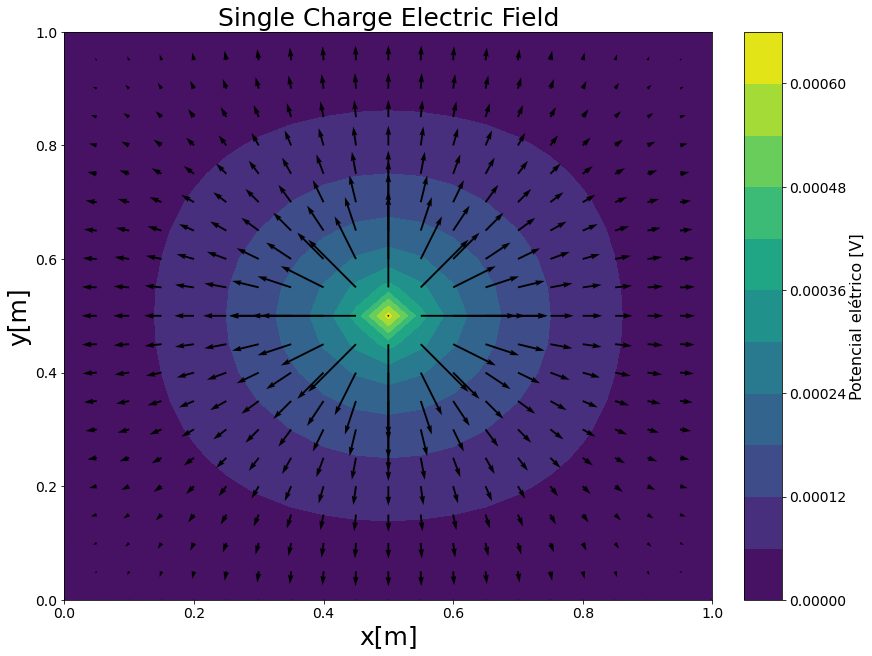

In [ ]:
# Example: Parallel Plates Capacitor + Single Charge


# Choose the grid dimensions
Lx = 1
Ly = Lx

#Choose the grid steps
dx = 0.05
dy = dx

# Choose your stop parameters
eps = 1e-16
Nmax = 1e3

# Create grid
x, y, xsize, ysize = create_grid(Lx, Ly, dx, dy)

# Initiate matrices
V, V_old, Ex, Ey, rho = initiate_matrices(xsize,ysize)

# Add charge distribution
create_rho(rho, [0.5], [0.5], [1])

# add border conditions
add_border_conditions(V, xsize, ysize, 0)

# Iterate and save vs, k and ds
vs, k, ds = iterate(V, V_old, eps, Nmax, rho, xsize, ysize)

# calculate the resulting electric field
E(V, Ex, Ey)

# plot everything
create_delta_plot(k, ds, 'Single Charge - Deltas')
create_basic_potential_plot(V, x, y, 'Single Charge')
create_field_plot(V, Ex, Ey, x, y, 'Single Charge Electric Field')

# The animation is commented because it could take a while.
# It is worth it, though

# create_animation(vs, x, y, 'animation_single_charge')


# Dipole

Last Delta = 9.780181222177053e-17
Last iteration = 739


<Figure size 432x288 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

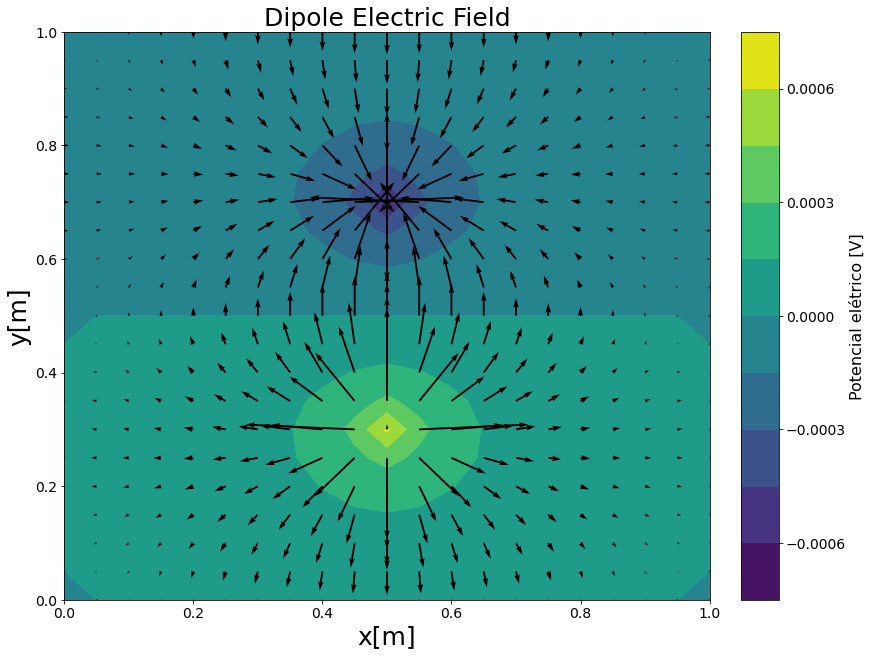

In [ ]:
# Example: Parallel Plates Capacitor + Single Charge


# Choose the grid dimensions
Lx = 1
Ly = Lx

#Choose the grid steps
dx = 0.05
dy = dx

# Choose your stop parameters
eps = 1e-16
Nmax = 1e3

# Create grid
x, y, xsize, ysize = create_grid(Lx, Ly, dx, dy)

# Initiate matrices
V, V_old, Ex, Ey, rho = initiate_matrices(xsize,ysize)

# Add charge distribution
create_rho(rho, [0.5, 0.5], [0.3, 0.7], [1,-1])

# add border conditions
add_border_conditions(V, xsize, ysize, 0)

# Iterate and save vs, k and ds
vs, k, ds = iterate(V, V_old, eps, Nmax, rho, xsize, ysize)

# calculate the resulting electric field
E(V, Ex, Ey)

# plot everything
create_delta_plot(k, ds, 'Dipole - Deltas')
create_basic_potential_plot(V, x, y, 'Dipole')
create_field_plot(V, Ex, Ey, x, y, 'Dipole Electric Field')

# The animation is commented because it could take a while.
# It is worth it, though

# create_animation(vs, x, y, 'animation_dipolo')
